In [1]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import pandas as pd
import tensorflow as tf
from keras.layers import LeakyReLU

#  Import and read the charity_data.csv.
import pandas as pd 
application_df = pd.read_csv("charity_data.csv")
application_df.head()

2023-01-14 10:07:49.927232: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


# First attempt - Remove ASK_AMT, and bucket INCOME_AMT into 2 bins

In [3]:
# Drop the non-beneficial ID columns, 'EIN' and 'NAME'.
application_df.drop(['EIN', 'NAME', 'ASK_AMT'], axis=1, inplace=True)
application_df.head()

,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,IS_SUCCESSFUL
0,T10,Independent,C1000,ProductDev,Association,1,0,N,1
1,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,1
2,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,0
3,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,1
4,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,1


In [4]:
# Determine the number of unique values in each column.
application_df.nunique()

APPLICATION_TYPE          17
AFFILIATION                6
CLASSIFICATION            71
USE_CASE                   5
ORGANIZATION               4
STATUS                     2
INCOME_AMT                 9
SPECIAL_CONSIDERATIONS     2
IS_SUCCESSFUL              2
dtype: int64

In [5]:
# Look at ASK_AMT value counts for binning
application_df.INCOME_AMT.value_counts()

0                24388
25000-99999       3747
100000-499999     3374
1M-5M              955
1-9999             728
10000-24999        543
10M-50M            240
5M-10M             185
50M+               139
Name: INCOME_AMT, dtype: int64

<AxesSubplot:ylabel='Density'>

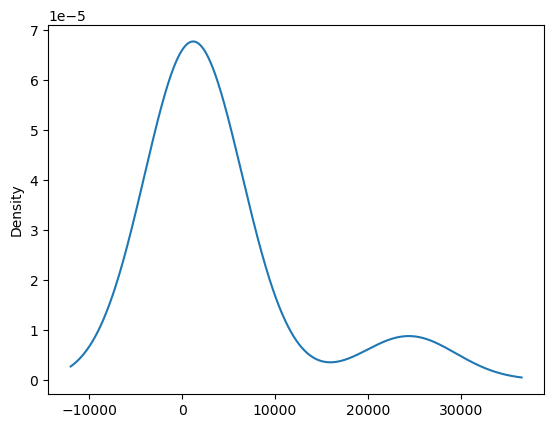

In [6]:
# Visualize the value counts of ASK_AMT
application_df.INCOME_AMT.value_counts().plot.density()

In [7]:
# Determine which values to replace if counts are less than ...?
replace_application = list(application_df.INCOME_AMT.value_counts()
                           [application_df.INCOME_AMT.value_counts() < 24000].index)

# Replace in dataframe
for app in replace_application:
    application_df.INCOME_AMT = application_df.INCOME_AMT.replace(app,"Over 0")
    
# Check to make sure binning was successful
application_df.INCOME_AMT.value_counts()

0         24388
Over 0     9911
Name: INCOME_AMT, dtype: int64

In [8]:
# Determine which values to replace if counts are less than ...?
replace_application = list(application_df.APPLICATION_TYPE.value_counts()
                           [application_df.APPLICATION_TYPE.value_counts() < 520].index)

# Replace in dataframe
for app in replace_application:
    application_df.APPLICATION_TYPE = application_df.APPLICATION_TYPE.replace(app,"Other")
    
# Check to make sure binning was successful
application_df.APPLICATION_TYPE.value_counts()

T3       27037
T4        1542
T6        1216
T5        1173
T19       1065
T8         737
T7         725
T10        528
Other      276
Name: APPLICATION_TYPE, dtype: int64

In [9]:
class_count_df = application_df.CLASSIFICATION.value_counts()
class_count_df.head(20)

C1000    17326
C2000     6074
C1200     4837
C3000     1918
C2100     1883
C7000      777
C1700      287
C4000      194
C5000      116
C1270      114
C2700      104
C2800       95
C7100       75
C1300       58
C1280       50
C1230       36
C1400       34
C7200       32
C2300       32
C1240       30
Name: CLASSIFICATION, dtype: int64

In [10]:
# Determine which values to replace if counts are less than ..?
replace_class = list(application_df.CLASSIFICATION.value_counts()
                           [application_df.CLASSIFICATION.value_counts() < 1500].index)

# Replace in dataframe
for cls in replace_class:
    application_df.CLASSIFICATION = application_df.CLASSIFICATION.replace(cls,"Other")
    
# Check to make sure binning was successful
application_df.CLASSIFICATION.value_counts()

C1000    17326
C2000     6074
C1200     4837
Other     2261
C3000     1918
C2100     1883
Name: CLASSIFICATION, dtype: int64

In [11]:
# Generate our categorical variable lists
application_cat = application_df.dtypes[application_df.dtypes == "object"].index.tolist()
application_cat

['APPLICATION_TYPE',
 'AFFILIATION',
 'CLASSIFICATION',
 'USE_CASE',
 'ORGANIZATION',
 'INCOME_AMT',
 'SPECIAL_CONSIDERATIONS']

In [12]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(application_df[application_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(application_cat)
encode_df.head()

/Users/emily/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,APPLICATION_TYPE_T8,AFFILIATION_CompanySponsored,...,USE_CASE_Preservation,USE_CASE_ProductDev,ORGANIZATION_Association,ORGANIZATION_Co-operative,ORGANIZATION_Corporation,ORGANIZATION_Trust,INCOME_AMT_0,INCOME_AMT_Over 0,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0


In [13]:
# Merge one-hot encoded features and drop the originals
application_df = application_df.merge(encode_df,left_index=True, right_index=True)
application_df = application_df.drop(application_cat,1)
application_df.head()

/Users/emily/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


,STATUS,IS_SUCCESSFUL,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,...,USE_CASE_Preservation,USE_CASE_ProductDev,ORGANIZATION_Association,ORGANIZATION_Co-operative,ORGANIZATION_Corporation,ORGANIZATION_Trust,INCOME_AMT_0,INCOME_AMT_Over 0,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,1,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
2,1,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
4,1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0


In [14]:
# Split our preprocessed data into our features and target arrays
y = application_df['IS_SUCCESSFUL'].values
X = application_df.drop(["IS_SUCCESSFUL"],1).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

/Users/emily/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


In [15]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [16]:
len(X_train[0])

35

In [17]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train[0])
hidden_nodes_layer1 = 80
hidden_nodes_layer2 = 30
#hidden_nodes_layer3 = 10

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Third hidden layer
#nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation="tanh"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

2023-01-14 10:08:00.349061: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                2880      
                                                                 
 dense_1 (Dense)             (None, 30)                2430      
                                                                 
 dense_2 (Dense)             (None, 1)                 31        
                                                                 
Total params: 5,341
Trainable params: 5,341
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [19]:
# Train the model
fit_model = nn.fit(X_train,y_train,epochs=50)

Epoch 1/50
804/804 [==============================] - 2s 1ms/step - loss: 0.5775 - accuracy: 0.7151
Epoch 2/50
804/804 [==============================] - 1s 1ms/step - loss: 0.5596 - accuracy: 0.7246
Epoch 3/50
804/804 [==============================] - 1s 1ms/step - loss: 0.5568 - accuracy: 0.7255
Epoch 4/50
804/804 [==============================] - 1s 1ms/step - loss: 0.5550 - accuracy: 0.7255
Epoch 5/50
804/804 [==============================] - 1s 1ms/step - loss: 0.5548 - accuracy: 0.7265
Epoch 6/50
804/804 [==============================] - 1s 1ms/step - loss: 0.5536 - accuracy: 0.7255
Epoch 7/50
804/804 [==============================] - 1s 1ms/step - loss: 0.5533 - accuracy: 0.7276
Epoch 8/50
804/804 [==============================] - 1s 1ms/step - loss: 0.5533 - accuracy: 0.7252
Epoch 9/50
804/804 [==============================] - 1s 1ms/step - loss: 0.5522 - accuracy: 0.7289
Epoch 10/50
804/804 [==============================] - 1s 1ms/step - loss: 0.5520 - accuracy: 0.7275

In [20]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 2.1558 - accuracy: 0.6857 - 325ms/epoch - 1ms/step
Loss: 2.155785083770752, Accuracy: 0.6857143044471741


In [21]:
# Import checkpoint dependencies
import os
from tensorflow.keras.callbacks import ModelCheckpoint

In [22]:
# Define the checkpoint path and filenames
os.makedirs("checkpoints/",exist_ok=True)
checkpoint_path = "checkpoints/weights.{epoch:02d}.hdf5"

In [24]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Create a callback that saves the model's weights every epoch
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq='epoch',
    period=5)

# Train the model
fit_model = nn.fit(X_train_scaled,y_train,epochs=50,callbacks=[cp_callback])

# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/50
804/804 [==============================] - 2s 1ms/step - loss: 0.5462 - accuracy: 0.7327
Epoch 2/50
804/804 [==============================] - 1s 1ms/step - loss: 0.5461 - accuracy: 0.7315
Epoch 3/50
804/804 [==============================] - 1s 1ms/step - loss: 0.5467 - accuracy: 0.7309
Epoch 4/50
804/804 [==============================] - 1s 1ms/step - loss: 0.5458 - accuracy: 0.7314
Epoch 5/50
768/804 [===========================>..] - ETA: 0s - loss: 0.5453 - accuracy: 0.7315
Epoch 5: saving model to checkpoints/weights.05.hdf5
804/804 [==============================] - 1s 1ms/step - loss: 0.5461 - accuracy: 0.7315
Epoch 6/50
804/804 [==============================] - 1s 1ms/step - loss: 0.5458 - accuracy: 0.7317
Epoch 7/50
804/804 [==============================] - 1s 1ms/step - loss: 0.5458 - accuracy: 0.7316
Epoch 8/50
804/804 [==============================] - 1s 1ms/step - loss: 0.5456 - accuracy: 0.7316
Epoch 9/50
804/804 [==============================] - 1s 1ms/s

# Attempt 2 - Add nodes to 1st hidden layer

In [30]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train[0])
hidden_nodes_layer1 = 140
hidden_nodes_layer2 = 30
#hidden_nodes_layer3 = 10

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Third hidden layer
#nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation="tanh"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 140)               5040      
                                                                 
 dense_19 (Dense)            (None, 30)                4230      
                                                                 
 dense_20 (Dense)            (None, 1)                 31        
                                                                 
Total params: 9,301
Trainable params: 9,301
Non-trainable params: 0
_________________________________________________________________


In [32]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [33]:
# Train the model
fit_model = nn.fit(X_train,y_train,epochs=50)

Epoch 1/50
804/804 [==============================] - 2s 1ms/step - loss: 0.5717 - accuracy: 0.7193
Epoch 2/50
804/804 [==============================] - 1s 1ms/step - loss: 0.5595 - accuracy: 0.7251
Epoch 3/50
804/804 [==============================] - 1s 2ms/step - loss: 0.5572 - accuracy: 0.7243
Epoch 4/50
804/804 [==============================] - 1s 2ms/step - loss: 0.5548 - accuracy: 0.7268
Epoch 5/50
804/804 [==============================] - 1s 2ms/step - loss: 0.5549 - accuracy: 0.7269
Epoch 6/50
804/804 [==============================] - 1s 1ms/step - loss: 0.5540 - accuracy: 0.7294
Epoch 7/50
804/804 [==============================] - 1s 2ms/step - loss: 0.5537 - accuracy: 0.7275
Epoch 8/50
804/804 [==============================] - 1s 2ms/step - loss: 0.5534 - accuracy: 0.7283
Epoch 9/50
804/804 [==============================] - 1s 1ms/step - loss: 0.5522 - accuracy: 0.7287
Epoch 10/50
804/804 [==============================] - 1s 1ms/step - loss: 0.5519 - accuracy: 0.7287

In [34]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 3.2130 - accuracy: 0.6471 - 335ms/epoch - 1ms/step
Loss: 3.212955951690674, Accuracy: 0.6471136808395386


In [35]:
# Define the checkpoint path and filenames
os.makedirs("checkpoints/",exist_ok=True)
checkpoint_path = "checkpoints/weights.{epoch:02d}.hdf5"

In [36]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Create a callback that saves the model's weights every epoch
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq='epoch',
    period=5)

# Train the model
fit_model = nn.fit(X_train_scaled,y_train,epochs=50,callbacks=[cp_callback])

# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/50
804/804 [==============================] - 2s 1ms/step - loss: 0.9213 - accuracy: 0.7194
Epoch 2/50
804/804 [==============================] - 1s 2ms/step - loss: 0.5824 - accuracy: 0.7243
Epoch 3/50
804/804 [==============================] - 1s 1ms/step - loss: 0.5701 - accuracy: 0.7265
Epoch 4/50
804/804 [==============================] - 1s 2ms/step - loss: 0.5703 - accuracy: 0.7273
Epoch 5/50
780/804 [============================>.] - ETA: 0s - loss: 0.5685 - accuracy: 0.7270
Epoch 5: saving model to checkpoints/weights.05.hdf5
804/804 [==============================] - 1s 1ms/step - loss: 0.5695 - accuracy: 0.7266
Epoch 6/50
804/804 [==============================] - 1s 1ms/step - loss: 0.5680 - accuracy: 0.7262
Epoch 7/50
804/804 [==============================] - 1s 1ms/step - loss: 0.5592 - accuracy: 0.7289
Epoch 8/50
804/804 [==============================] - 1s 1ms/step - loss: 0.5675 - accuracy: 0.7293
Epoch 9/50
804/804 [==============================] - 1s 1ms/s

# Attempt 3 - Add another hidden layer and change activation

In [37]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train[0])
hidden_nodes_layer1 = 140
hidden_nodes_layer2 = 30
hidden_nodes_layer3 = 10

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="tanh")
)

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="tanh"))

# Third hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation="tanh"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 140)               5040      
                                                                 
 dense_22 (Dense)            (None, 30)                4230      
                                                                 
 dense_23 (Dense)            (None, 10)                310       
                                                                 
 dense_24 (Dense)            (None, 1)                 11        
                                                                 
Total params: 9,591
Trainable params: 9,591
Non-trainable params: 0
_________________________________________________________________


In [38]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [39]:
# Train the model
fit_model = nn.fit(X_train,y_train,epochs=50)

Epoch 1/50
804/804 [==============================] - 2s 1ms/step - loss: 0.5769 - accuracy: 0.7172
Epoch 2/50
804/804 [==============================] - 1s 2ms/step - loss: 0.5617 - accuracy: 0.7251
Epoch 3/50
804/804 [==============================] - 1s 2ms/step - loss: 0.5596 - accuracy: 0.7253
Epoch 4/50
804/804 [==============================] - 1s 2ms/step - loss: 0.5579 - accuracy: 0.7261
Epoch 5/50
804/804 [==============================] - 1s 2ms/step - loss: 0.5566 - accuracy: 0.7261
Epoch 6/50
804/804 [==============================] - 1s 1ms/step - loss: 0.5557 - accuracy: 0.7273
Epoch 7/50
804/804 [==============================] - 1s 1ms/step - loss: 0.5550 - accuracy: 0.7264
Epoch 8/50
804/804 [==============================] - 1s 1ms/step - loss: 0.5542 - accuracy: 0.7269
Epoch 9/50
804/804 [==============================] - 1s 2ms/step - loss: 0.5542 - accuracy: 0.7255
Epoch 10/50
804/804 [==============================] - 1s 2ms/step - loss: 0.5533 - accuracy: 0.7269

In [40]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.6087 - accuracy: 0.7051 - 320ms/epoch - 1ms/step
Loss: 0.6086869239807129, Accuracy: 0.7050728797912598


In [41]:
# Define the checkpoint path and filenames
os.makedirs("checkpoints/",exist_ok=True)
checkpoint_path = "checkpoints/weights.{epoch:02d}.hdf5"

In [42]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Create a callback that saves the model's weights every epoch
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq='epoch',
    period=5)

# Train the model
fit_model = nn.fit(X_train_scaled,y_train,epochs=50,callbacks=[cp_callback])

# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/50
804/804 [==============================] - 2s 1ms/step - loss: 0.5630 - accuracy: 0.7237
Epoch 2/50
804/804 [==============================] - 1s 1ms/step - loss: 0.5536 - accuracy: 0.7266
Epoch 3/50
804/804 [==============================] - 1s 1ms/step - loss: 0.5522 - accuracy: 0.7272
Epoch 4/50
804/804 [==============================] - 1s 1ms/step - loss: 0.5505 - accuracy: 0.7293
Epoch 5/50
795/804 [============================>.] - ETA: 0s - loss: 0.5505 - accuracy: 0.7296
Epoch 5: saving model to checkpoints/weights.05.hdf5
804/804 [==============================] - 1s 1ms/step - loss: 0.5504 - accuracy: 0.7295
Epoch 6/50
804/804 [==============================] - 1s 1ms/step - loss: 0.5494 - accuracy: 0.7304
Epoch 7/50
804/804 [==============================] - 1s 1ms/step - loss: 0.5492 - accuracy: 0.7296
Epoch 8/50
804/804 [==============================] - 1s 1ms/step - loss: 0.5486 - accuracy: 0.7304
Epoch 9/50
804/804 [==============================] - 1s 1ms/s

In [43]:
#Save and export your results to an HDF5 file
nn.save("AlphabetSoupCharity_Optimization.h5")